# Chapter 13: Modeling continuous relationships

In [2]:
library(tidyverse)
library(ggplot2)
library(fivethirtyeight)
library(BayesFactor)
library(bayestestR)
library(cowplot)
library(knitr)
library(DiagrammeR)
library(htmltools)
library(webshot)
theme_set(theme_minimal(base_size = 14))

set.seed(123456) # set random seed to exactly replicate results

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(Weight) %>%
  subset(Age>=18)

## Figure 13.1

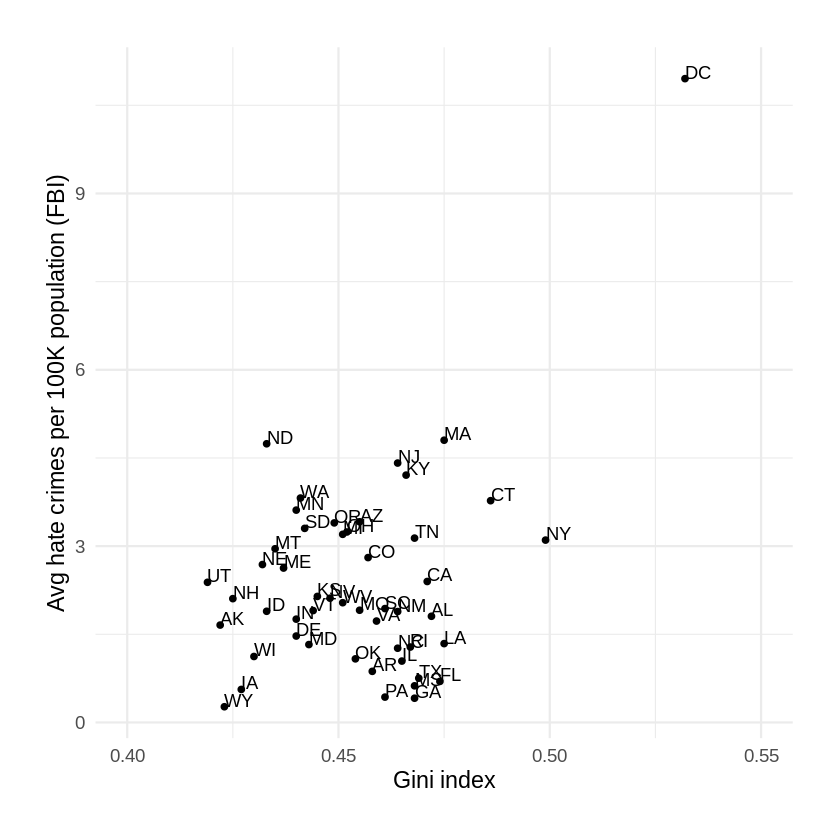

In [3]:
hateCrimes <-
  hate_crimes %>%
  mutate(state_abb = state.abb[match(state,state.name)]) %>%
  drop_na(avg_hatecrimes_per_100k_fbi)

hateCrimes$state_abb[hateCrimes$state=="District of Columbia"]='DC'

ggplot(hateCrimes,aes(gini_index,avg_hatecrimes_per_100k_fbi,label=state_abb)) +
  geom_point() +
  geom_text(aes(label=state_abb),hjust=0, vjust=0) +
  theme(plot.title = element_text(size = 20, face = "bold")) +
  xlab('Gini index') +
  ylab('Avg hate crimes per 100K population (FBI)') +
  theme(plot.margin = unit(c(1,1,1,1), "cm")) +
  xlim(0.4, 0.55)

## Table 13.1

In [4]:
# create data for toy example of covariance
df <-
  tibble(x = c(3, 5, 8, 10, 12)) %>%
  mutate(y = x + round(rnorm(n = 5, mean = 0, sd = 2))) %>%
  mutate(
    y_dev = y - mean(y),
    x_dev = x - mean(x)
  ) %>%
  mutate(crossproduct = y_dev * x_dev)

covXY <- sum(df$crossproduct) / (nrow(df) - 1)
corXY <- sum(df$crossproduct) / ((nrow(df) - 1) * sd(df$x) * sd(df$y))

kable(df, caption='Data for toy example of covariance')



Table: Data for toy example of covariance

|  x|  y| y_dev| x_dev| crossproduct|
|--:|--:|-----:|-----:|------------:|
|  3|  5|  -3.6|  -4.6|        16.56|
|  5|  4|  -4.6|  -2.6|        11.96|
|  8|  7|  -1.6|   0.4|        -0.64|
| 10| 10|   1.4|   2.4|         3.36|
| 12| 17|   8.4|   4.4|        36.96|

### Hypothesis testing for correlations

In [5]:
# perform correlation test on hate crime data
cor.test(
  hateCrimes$avg_hatecrimes_per_100k_fbi,
  hateCrimes$gini_index
)


	Pearson's product-moment correlation

data:  hateCrimes$avg_hatecrimes_per_100k_fbi and hateCrimes$gini_index
t = 3.2182, df = 48, p-value = 0.002314
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1619097 0.6261922
sample estimates:
      cor 
0.4212719 


## Figure 13.2

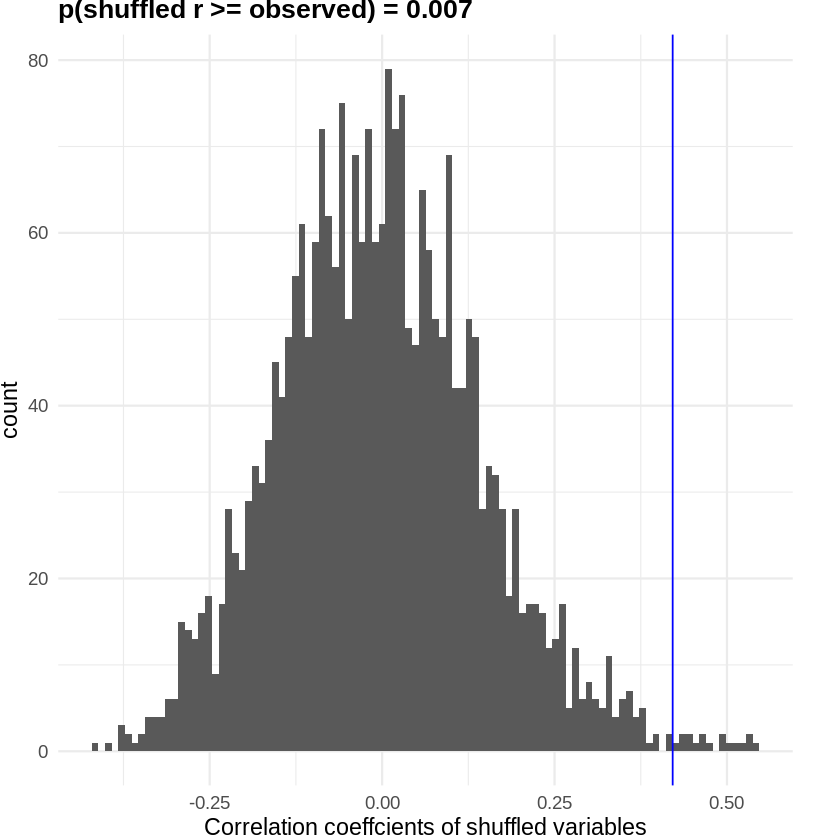

In [6]:
corGiniHC <-
  cor(
    hateCrimes$gini_index,
    hateCrimes$avg_hatecrimes_per_100k_fbi
  )

# compute null distribution by shuffling order of variable values

# create a function to compute the correlation on the shuffled values
shuffleCorr <- function(x, y) {
  xShuffled <- sample(x)
  return(cor(xShuffled, y))
}

# run this function 2500 times
shuffleDist <-
  replicate(
    2500,
    shuffleCorr(hateCrimes$avg_hatecrimes_per_100k_fbi, hateCrimes$gini_index)
  )

ggplot(data.frame(shuffleDist),aes(shuffleDist)) +
  geom_histogram(bins=100) +
  geom_vline(xintercept = corGiniHC,color='blue') +
  ggtitle(sprintf('p(shuffled r >= observed) = %0.3f',mean(shuffleDist>=corGiniHC))) +
  theme(plot.title = element_text(size = 16, face = "bold")) +
  theme(plot.margin = unit(c(0,1,0,0), "cm")) +
  labs(
  x = "Correlation coeffcients of shuffled variables"
  )

## Figure 13.3

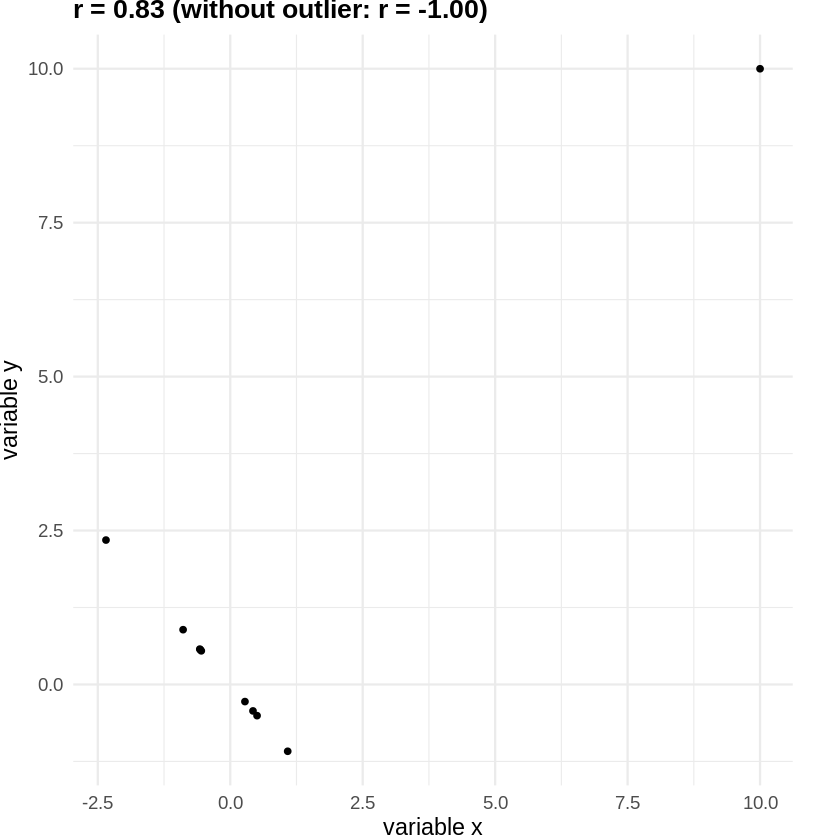

In [7]:
n <- 10
set.seed(1234)

dfOutlier <-
  data.frame(x = rnorm(n)) %>%
  mutate(y = x * -1)

dfOutlier$x[1] <- 10
dfOutlier$y[1] <- 10
cc <- cor(dfOutlier$x, dfOutlier$y)
ccSpearman <- cor(dfOutlier$x, dfOutlier$y, method = "spearman")

p <- ggplot(dfOutlier, aes(x, y)) +
  geom_point() +
  ggtitle(sprintf("r = %0.2f (without outlier: r = %.2f)", cc, cor(dfOutlier$x[2:n], dfOutlier$y[2:n]))) +
  theme(plot.title = element_text(size = 16, face = "bold")) +
  theme(plot.margin = unit(c(0, 1, 0, 0), "cm")) +
  labs(
    x = "variable x",
    y = "variable y"
  )
print(p)

## Spearman correlation test

In [8]:
corTestSpearman <- cor.test( hateCrimes$avg_hatecrimes_per_100k_fbi,
  hateCrimes$gini_index,
  method = "spearman")
corTestSpearman

Warning message in cor.test.default(hateCrimes$avg_hatecrimes_per_100k_fbi, hateCrimes$gini_index, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  hateCrimes$avg_hatecrimes_per_100k_fbi and hateCrimes$gini_index
S = 20146, p-value = 0.8221
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.03261836 


## Figure 13.6

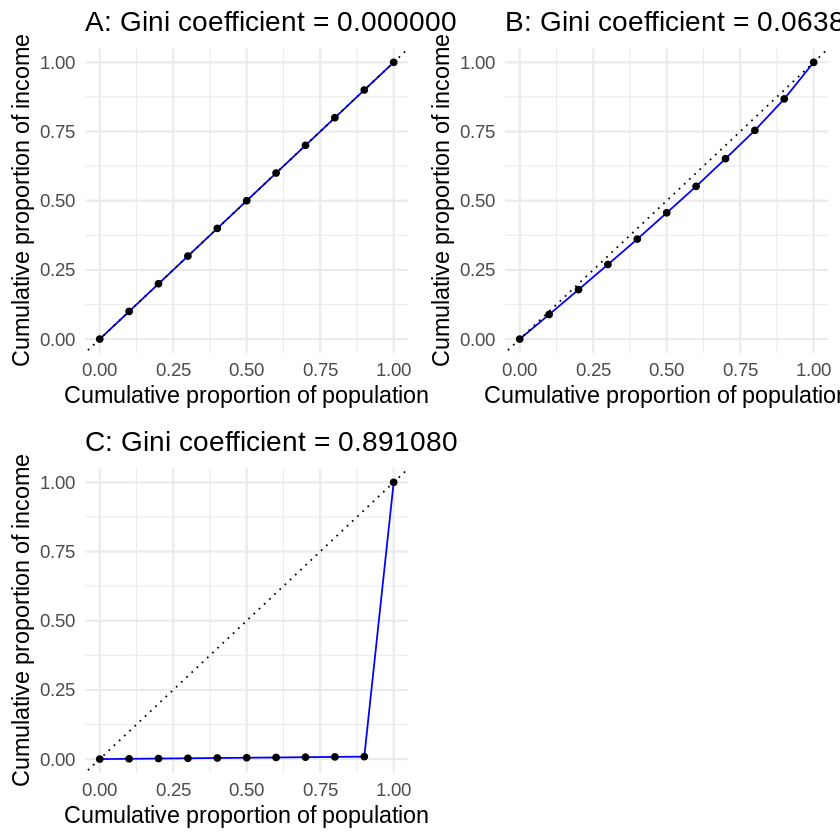

In [9]:
# function to generate a plot of Lorenz curve and compute Gini coefficient
lorenzCurve = function(df){
  df <- df %>% arrange(income)
  sumIncome <- sum(df$income)
  lc <- array(NA,nrow(df)+1)
  p <- array(NA,nrow(df)+1)
  lc[1] <- 0
  p[1] <- 0
  for (i in 1:nrow(df)){
    lc[i+1] <- sum(df$income[1:i])/sumIncome
    p[i+1] <- i/nrow(df)
  }
  S <- sum(lc)
  giniCoef <- 1 + (1-2*S)/nrow(df)
  return(list(p=p,lc=lc,gc=giniCoef))
}

incomeDf <- data.frame(income=rep(40000,10))
lc <- lorenzCurve(incomeDf)

incomeDf <- data.frame(income=rnorm(10,mean=40000,sd=5000))
lc2 <- lorenzCurve(incomeDf)

incomeDf <- data.frame(income=rep(40000,10))
incomeDf$income[1] <- 40000000
lc3 <- lorenzCurve(incomeDf)

p1 <- ggplot(data.frame(p=lc$p,lc=lc$lc),aes(p,lc)) +
    geom_line(color='blue') +
    geom_point() +
    xlim(0,1) + ylim(0,1) +
    xlab('Cumulative proportion of population') +
    ylab('Cumulative proportion of income') +
    geom_abline(slope=1,intercept = 0,color='black',linetype='dotted') +
    ggtitle(sprintf('A: Gini coefficient = %f',lc$gc))

p2 <- ggplot(data.frame(p=lc2$p,lc=lc2$lc),aes(p,lc)) +
    geom_line(color='blue') +
    geom_point() +
    xlim(0,1) + ylim(0,1) +
    xlab('Cumulative proportion of population') +
    ylab('Cumulative proportion of income') +
    geom_abline(slope=1,intercept = 0,color='black',linetype='dotted') +
    ggtitle(sprintf('B: Gini coefficient = %f',lc2$gc))

p3 <- ggplot(data.frame(p=lc3$p,lc=lc3$lc),aes(p,lc)) +
    geom_line(color='blue') +
    geom_point() +
    xlim(0,1) + ylim(0,1) +
    xlab('Cumulative proportion of population') +
    ylab('Cumulative proportion of income') +
    geom_abline(slope=1,intercept = 0,color='black',linetype='dotted') +
    ggtitle(sprintf('C: Gini coefficient = %f',lc3$gc))

plot_grid(p1,p2,p3,ncol=2)

## Bayesian correlation analysis


In [10]:
bayesCor <- correlationBF(
  hateCrimes$avg_hatecrimes_per_100k_fbi,
  hateCrimes$gini_index
)
print(bayesCor)
bayesCorPosterior <- describe_posterior(bayesCor)
print(bayesCorPosterior)

Bayes factor analysis
--------------
[1] Alt., r=0.333 : 20.85446 ±0%

Against denominator:
  Null, rho = 0 
---
Bayes factor type: BFcorrelation, Jeffreys-beta*

Summary of Posterior Distribution

Parameter | Median |       95% CI |     pd |          ROPE | % in ROPE |    BF |         Prior
----------------------------------------------------------------------------------------------
rho       |   0.38 | [0.13, 0.58] | 99.88% | [-0.05, 0.05] |        0% | 20.85 | Beta (3 +- 3)
